In [140]:

import matplotlib.pyplot as plt
plt.style.use('/home/joliveira/Documents/franck-hertz/joao.mplstyle')
# --- DEFINIÇÃO DO TEMA GLOBAL USANDO rcParams ---
plt.rcParams['figure.figsize'] = (20, 12) # Define o tamanho da figura para 10x6 polegadas
plt.rcParams['font.size'] = 14           # Define o tamanho da fonte geral como 14
plt.rcParams['axes.titlesize'] = 25      # Tamanho da fonte do título
plt.rcParams['axes.labelsize'] = 20      # Tamanho da fonte dos rótulos dos eixos
plt.rcParams['axes.grid'] = True        # Habilita/desabilita a grade em todos os gráficos
plt.rcParams['grid.linestyle'] = '-'      # Estilo da grade: tracejado
plt.rcParams['grid.alpha'] = 0.6         # Transparência da grade
plt.rcParams['grid.linewidth'] = 0.8
plt.rcParams['savefig.dpi'] = 700        # Alta resolução para salvar as figuras
plt.rcParams['lines.linestyle'] = '-'    # Linha sólida
plt.rcParams['lines.linewidth'] = 3   # Espessura da linha
plt.rcParams['figure.facecolor'] = 'none'   # Fundo da figura transparente
plt.rcParams['axes.facecolor']   = 'none'   # Fundo dos eixos transparente
plt.rcParams['savefig.facecolor'] = 'none'  # Ao salvar, mantém transparente
plt.rcParams['savefig.transparent'] = True  # Salva figuras com fundo transparente
plt.rcParams['xtick.labelsize'] = 16    # Tamanho dos rótulos do eixo x
plt.rcParams['ytick.labelsize'] = 16    # Tamanho dos rótulos do eixo y
# ---------------------------------------------------



Missing colon in file '/home/joliveira/Documents/franck-hertz/joao.mplstyle', line 617 ('view raw')
Missing colon in file '/home/joliveira/Documents/franck-hertz/joao.mplstyle', line 618 ('matplotlibrc hosted with ❤ by GitHub')


In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.optimize import curve_fit

def plot_corrente_tensao(
    caminho_arquivo: str,
    normalizar: bool = False,
    salvar: bool = False,
    pasta_saida: str = None,
    mostrar_fitting: bool = False
):
    """
    Lê um arquivo .ods e plota Corrente vs Tensão com barras de erro.
    Opcionalmente, realiza um fitting da forma j = A * V^(3/2).

    Parâmetros:
    - caminho_arquivo: str → caminho do arquivo .ods
    - normalizar: bool → se True, aplica normalização (max-min) na Corrente
    - salvar: bool → se True, salva o gráfico em PNG
    - pasta_saida: str → caminho onde o arquivo será salvo (obrigatório se salvar=True)
    - mostrar_fitting: bool → se True, realiza e exibe o ajuste j = A * V^(3/2)
    """

    # Ler a planilha
    df = pd.read_excel(caminho_arquivo, engine="odf")

    # Garantir que as colunas necessárias existam
    colunas_necessarias = ["Tensao", "Corrente", "Incerteza corrente"]
    for col in colunas_necessarias:
        if col not in df.columns:
            raise ValueError(f"Coluna '{col}' não encontrada no arquivo {caminho_arquivo}")

    # Guardar o valor máximo da corrente original
    corrente_max = df["Corrente"].max()

    # Normalização (opcional)
    if normalizar:
        df["Corrente"] = (df["Corrente"] - df["Corrente"].min()) / (df["Corrente"].max() - df["Corrente"].min())
        df["Incerteza corrente"] = df["Incerteza corrente"] / (corrente_max - df["Corrente"].min())

    # --- Plot dos dados experimentais ---
    plt.errorbar(
        df["Tensao"],
        df["Corrente"],
        yerr=df["Incerteza corrente"],
        fmt='-D',
        ecolor='gray',
        elinewidth=1,
        capsize=3,
        label='Medição com incerteza'
    )

    # --- Fitting (opcional) ---
    if mostrar_fitting:
        def child_langmuir(V, A):
            return A * V**(3/2)

        try:
            popt, pcov = curve_fit(child_langmuir, df["Tensao"], df["Corrente"])
            A_fit = popt[0]
            A_err = np.sqrt(np.diag(pcov))[0]

            # Curva ajustada
            V_fit = np.linspace(df["Tensao"].min(), df["Tensao"].max(), 300)
            I_fit = child_langmuir(V_fit, A_fit)

            plt.plot(V_fit, I_fit, '--r', label=f"Fit: $I = {A_fit:.2e} \\cdot V^{{3/2}}$\n(A ± σ = {A_err:.1e})")
        except Exception as e:
            print(f"⚠️ Erro ao ajustar os dados: {e}")

    # --- Configurações do gráfico ---
    plt.xlabel("Tensão (V)")
    plt.ylabel("Corrente (A)" if not normalizar else "Corrente (normalizada)")
    plt.title("Corrente vs Tensão" + (" (normalizado)" if normalizar else ""))
    plt.legend()
    plt.grid(True)

    # --- Anotação se normalizado ---
    if normalizar:
        plt.annotate(
            f"Corrente máxima: {corrente_max:.2e} A",
            xy=(0.99, 0.01),
            xycoords="axes fraction",
            xytext=(-10, 10),
            textcoords="offset points",
            ha="right",
            va="bottom",
            fontsize=12,
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", alpha=0.7)
        )

    plt.tight_layout()

    # --- Salvar ou mostrar ---
    if salvar:
        if pasta_saida is None:
            raise ValueError("Você deve fornecer o parâmetro 'pasta_saida' quando salvar=True.")

        os.makedirs(pasta_saida, exist_ok=True)
        nome_arquivo = os.path.splitext(os.path.basename(caminho_arquivo))[0]
        if normalizar:
            nome_arquivo += "_normalizado"
        nome_arquivo += ".png"

        caminho_saida = os.path.join(pasta_saida, nome_arquivo)
        plt.savefig(caminho_saida, dpi=300, bbox_inches="tight")
        print(f"✅ Gráfico salvo em: {caminho_saida}")
        plt.show()
        plt.close()
    else:
        plt.show()


In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

def plot_corrente_tensao_pasta(
    pasta_dados: str,
    normalizar: bool = False,
    salvar: bool = False,
    pasta_saida: str = None
):
    """
    Lê todos os arquivos .ods na pasta com nome no formato 'm_1-T_#C.ods'
    e plota Corrente vs Tensão para cada temperatura.

    Parâmetros:
    - pasta_dados: str → caminho da pasta contendo os arquivos .ods
    - normalizar: bool → se True, normaliza as correntes de todos os arquivos
                         pelo valor máximo global (corrente máxima entre todos)
    - salvar: bool → se True, salva o gráfico em PNG
    - pasta_saida: str → caminho onde o arquivo será salvo (obrigatório se salvar=True)
    """

    padrao_arquivo = re.compile(r"m_1-T_(\d+)C\.ods$")
    arquivos = [f for f in os.listdir(pasta_dados) if padrao_arquivo.match(f)]

    if not arquivos:
        raise FileNotFoundError("Nenhum arquivo encontrado com o padrão 'm_1-T_#C.ods'.")

    if salvar and pasta_saida is None:
        raise ValueError("Você deve fornecer o parâmetro 'pasta_saida' ao escolher salvar=True.")

    # Cria pasta de saída se necessário
    if salvar:
        os.makedirs(pasta_saida, exist_ok=True)

    dados_arquivos = []
    max_global = -float("inf")

    # --- Leitura e coleta do máximo global ---
    for arquivo in arquivos:
        caminho_arquivo = os.path.join(pasta_dados, arquivo)
        df = pd.read_excel(caminho_arquivo, engine="odf")

        # Checar colunas obrigatórias
        for col in ["Tensao", "Corrente", "Incerteza corrente"]:
            if col not in df.columns:
                raise ValueError(f"Coluna '{col}' não encontrada no arquivo {arquivo}")

        temperatura = int(padrao_arquivo.match(arquivo).group(1))
        corrente_max = df["Corrente"].max()
        max_global = max(max_global, corrente_max)

        dados_arquivos.append((temperatura, df, corrente_max))

    # --- Plotagem ---
    plt.figure()

    for temperatura, df, corrente_max in sorted(dados_arquivos):
        if normalizar:
            df["Corrente"] = df["Corrente"] / max_global
            df["Incerteza corrente"] = df["Incerteza corrente"] / max_global

        plt.errorbar(
            df["Tensao"],
            df["Corrente"],
            yerr=df["Incerteza corrente"],
            fmt='-D',
            capsize=3,
            label=f"{temperatura}°C"
        )

    plt.xlabel("Tensão (V)")
    plt.ylabel("Corrente (A)" if not normalizar else "Corrente (normalizada)")
    plt.title("Corrente vs Tensão para diferentes temperaturas" + (" (normalizado)" if normalizar else ""))
    plt.legend(title="Temperatura",
               fontsize=20)
    plt.grid(True)

    # --- Anotação de corrente máxima global ---
    if normalizar:
        plt.annotate(
            f"Corrente máxima global: {max_global:.2e} A",
            xy=(0.99, 0.01),
            xycoords="axes fraction",
            xytext=(-10, 10),
            textcoords="offset points",
            ha="right",
            va="bottom",
            fontsize=20,
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", alpha=0.7)
        )

    plt.tight_layout()

    # --- Salvar ou mostrar ---
    if salvar:
        nome_arquivo = "corrente_vs_tensao"
        if normalizar:
            nome_arquivo += "_normalizado"
        nome_arquivo += ".png"

        caminho_saida = os.path.join(pasta_saida, nome_arquivo)
        plt.savefig(caminho_saida, dpi=300, bbox_inches="tight")
        print(f"✅ Gráfico salvo em: {caminho_saida}")
        plt.show()
        plt.close()
    else:
        plt.show()


✅ Gráfico salvo em: Graficos Gerados/m_1-T_1600C_normalizado.png


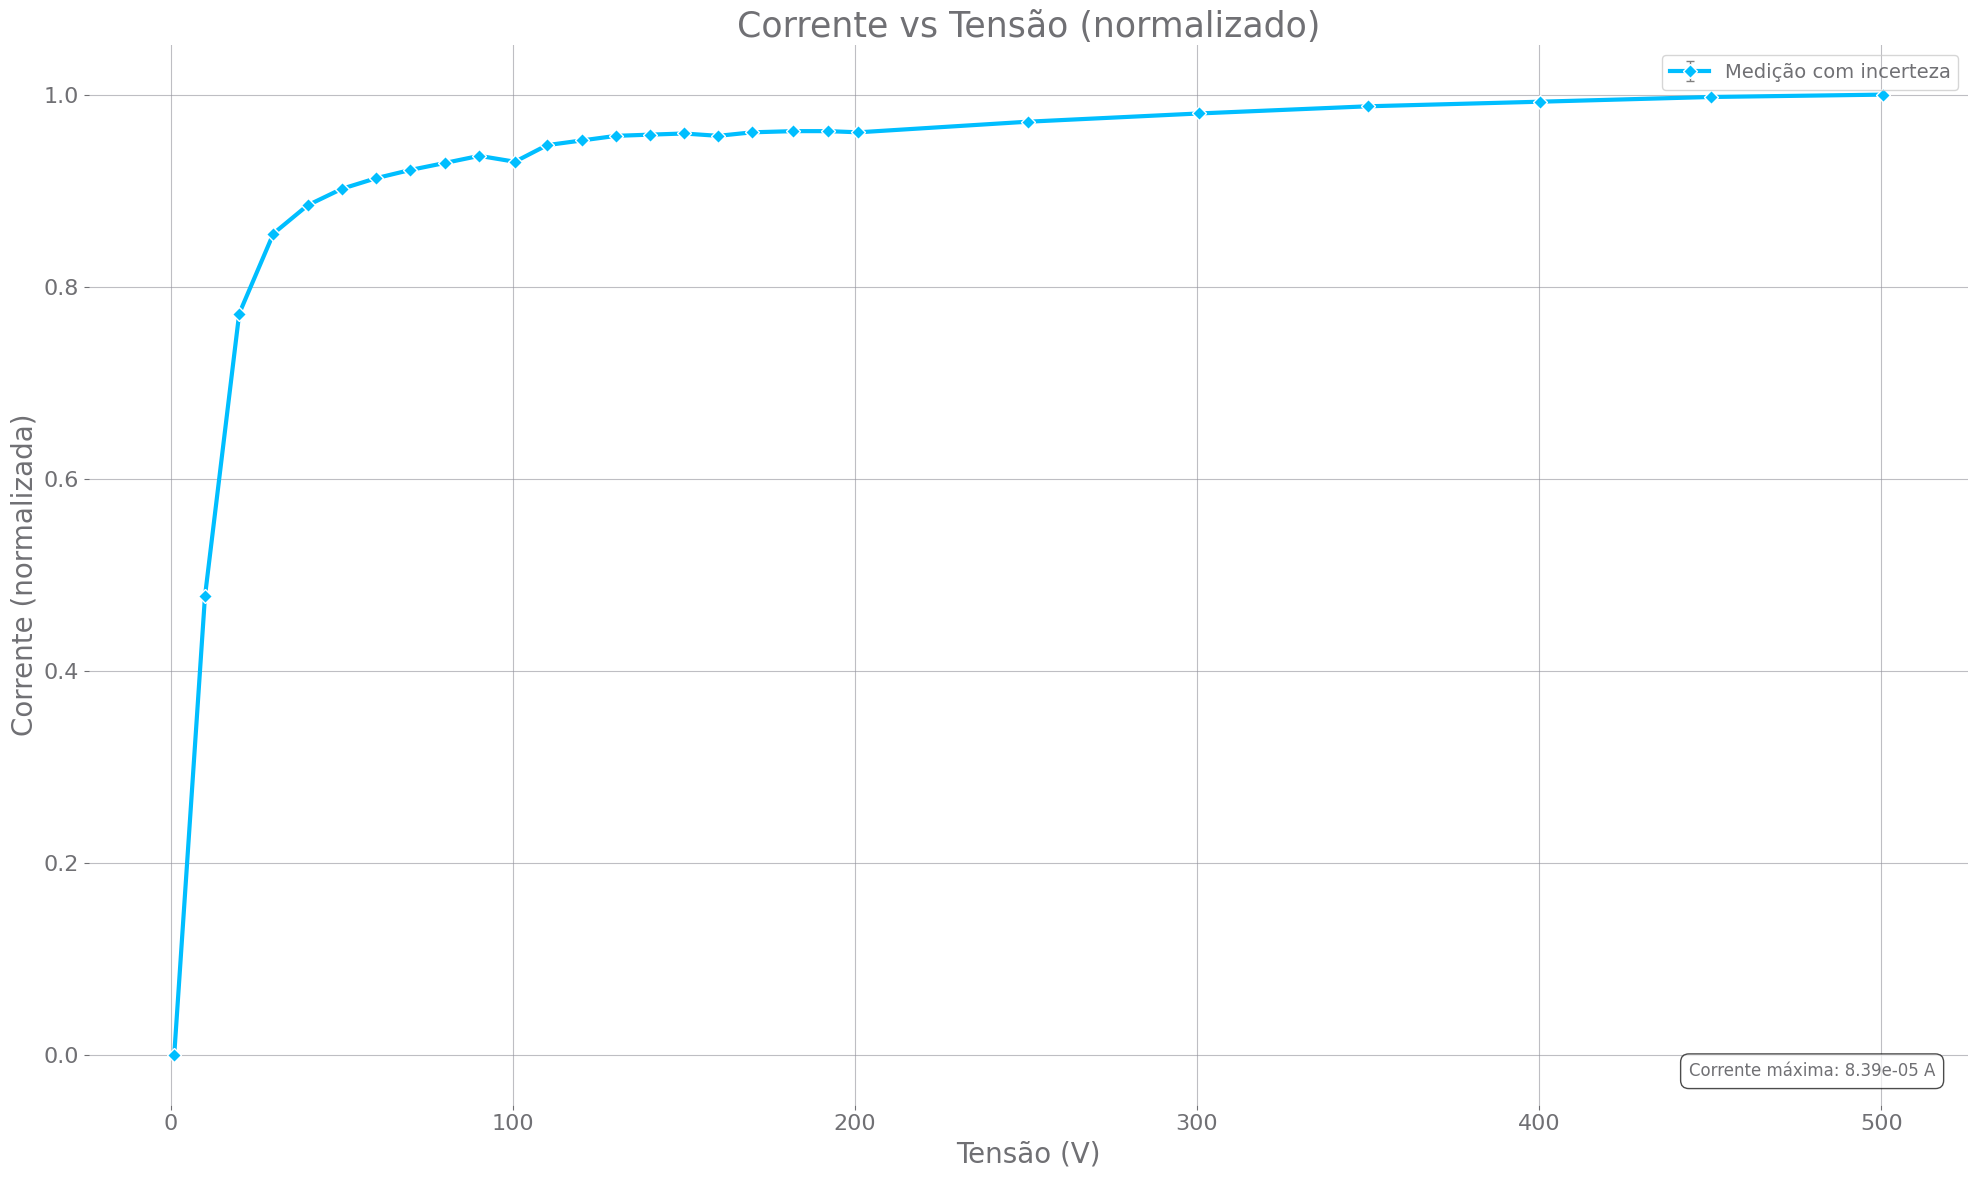

✅ Gráfico salvo em: Graficos Gerados/corrente_vs_tensao_normalizado.png


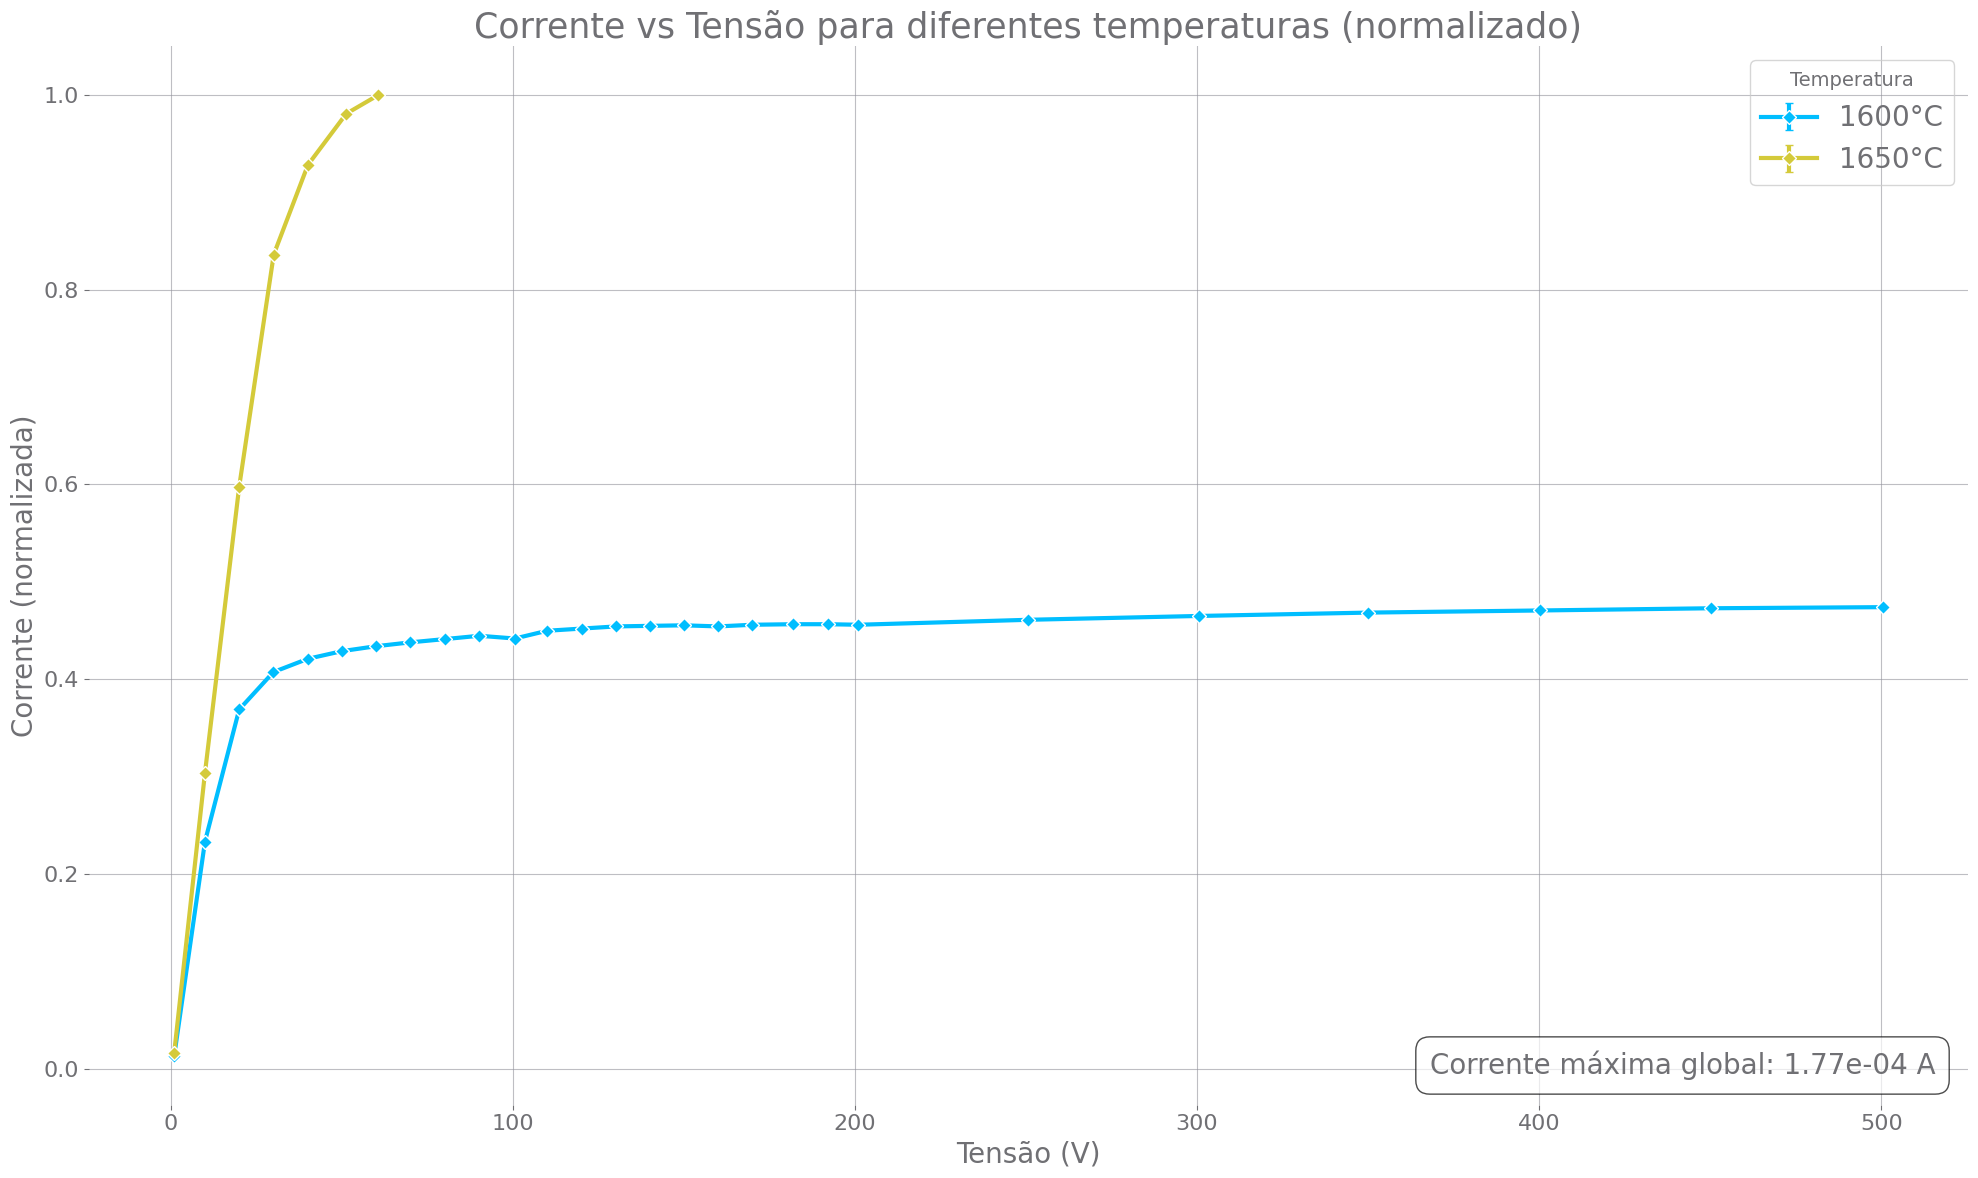

In [143]:
plot_corrente_tensao(
    caminho_arquivo="Dados Obtidos 06.11.2025/m_1-T_1600C.ods",
    normalizar=True,
    salvar=True,
    mostrar_fitting=False,  # mostra o ajuste da Lei de Child-Langmuir
    pasta_saida="Graficos Gerados/"
)
# Normalizar e salvar
plot_corrente_tensao_pasta(
    pasta_dados="Dados Obtidos 06.11.2025/",
    normalizar=True,
    salvar=True,
    pasta_saida="Graficos Gerados/"
)
